## Introduction


The Enron-Spam is a collection of spam/ham dataset by V. Metsis, I. Androutsopoulos and G. Paliouras and described in their publication "Spam Filtering with Naive Bayes - Which Naive Bayes?".
    
This dataset contains 17,171 spam and 16,545 non-spam ("ham") e-mail messages (33,716 in total).
The raw dataset and documentation can be accessed via the following link: http://www2.aueb.gr/users/ion/data/enron-spam/

The original dataset has every single mail in a seperate txt file and distributed over several directories.
The following repository (https://github.com/MWiechmann/enron_spam_data) converted the unprocessed data into a more structured format that offers a single download (https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip) of the data through a simple csv file, making further preprocessing of this dataset less cumbersome.

## Import Libraries

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import nltk
import re
from collections import Counter

## 1. Import and Read Data

In [251]:
enron_emails = pd.read_csv('../data/enron_spam_data.csv')

In [252]:
enron_emails.head(3)

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14


In [253]:
# verify total number of emails
print('There are', enron_emails.shape[0] ,'emails in the dataset')

There are 33716 emails in the dataset


In [254]:
print(enron_emails.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33716 non-null  int64 
 1   Subject     33427 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None


## 2. Basic Cleaning

### 2.1 Remove Message ID and Date

In [255]:
enron_emails.drop(['Message ID', 'Date'], axis = 1, inplace = True)

### 2.2 Missing Value Query for Ham and Spam
- Are there missing messages in both spam and ham?
- If missing values are minimal and cannot be imputed correctly without an expert, then drop those rows.
- Fill empty Subject cells with 'None'

In [256]:
hams = enron_emails[enron_emails['Spam/Ham'] == 'ham']
print('Ham Stats')
print(hams.info())
print(hams.Message.isnull().sum() / hams.shape[0] * 100, "% missing ham messages")

Ham Stats
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 29215
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   16545 non-null  object
 1   Message   16493 non-null  object
 2   Spam/Ham  16545 non-null  object
dtypes: object(3)
memory usage: 517.0+ KB
None
0.31429434874584466 % missing ham messages


In [257]:
spams = enron_emails[enron_emails['Spam/Ham'] == 'spam']
print('Spam Stats')
print(spams.info())
print(spams.Message.isnull().sum() / spams.shape[0] * 100, "% missing spam messages")

Spam Stats
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17171 entries, 3672 to 33715
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   16882 non-null  object
 1   Message   16852 non-null  object
 2   Spam/Ham  17171 non-null  object
dtypes: object(3)
memory usage: 536.6+ KB
None
1.8577834721332478 % missing spam messages


In [258]:
# Drop row if column value in Message is missing
# If subject is missing, fill in None

enron_emails.dropna(subset = ['Message'], inplace = True)
enron_emails.Subject.fillna('None', inplace = True)
print(enron_emails.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33345 entries, 1 to 33715
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   33345 non-null  object
 1   Message   33345 non-null  object
 2   Spam/Ham  33345 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
None


## 3. Create Additional Features

### 3.1 Create a binary label encoding on Spam/Ham

In [259]:
enron_emails['target'] = enron_emails['Spam/Ham'].map({'ham':0, 'spam':1})

enron_emails.head(3)

,Subject,Message,Spam/Ham,target
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0
3,re : issue,fyi - see note below - already done .\nstella\...,ham,0


### 3.2 Create columns to tally punctuation

In [260]:
for punctu in string.punctuation:
    enron_emails[punctu] = enron_emails['Message'].map(lambda v : v.count(punctu))

enron_emails.head(3)

,Subject,Message,Spam/Ham,target,!,"""",#,$,%,&,...,[,\,],^,_,`,{,|,},~
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0,0,2,4,0,1,0,...,0,0,0,0,0,0,0,254,0,0
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,re : issue,fyi - see note below - already done .\nstella\...,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.3 Create a column to tally message body length (via counting # of spaces)

In [261]:
enron_emails['msg_body_len'] = enron_emails.Message.apply(lambda x: len(x) - x.count(" "))

enron_emails.head(3)

,Subject,Message,Spam/Ham,target,!,"""",#,$,%,&,...,\,],^,_,`,{,|,},~,msg_body_len
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0,0,2,4,0,1,0,...,0,0,0,0,0,0,254,0,0,2823
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
3,re : issue,fyi - see note below - already done .\nstella\...,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,855


### 3.4 Create a column to accout for the % of punctuation to message body length

In [262]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100

enron_emails['punct%'] = enron_emails.Message.apply(lambda x: count_punct(x))

enron_emails.head(3)

,Subject,Message,Spam/Ham,target,!,"""",#,$,%,&,...,],^,_,`,{,|,},~,msg_body_len,punct%
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0,0,2,4,0,1,0,...,0,0,0,0,0,254,0,0,2823,40.5
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,6.5
3,re : issue,fyi - see note below - already done .\nstella\...,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,855,19.8


## 4. Cleaning Message

- #### Turn words into lowercase letters
- #### Remove numerical digits
- #### Remove punctuation
- #### Tokenization - split a sentence into a list of words 
- #### Remove stopwords - to remove tokens not contributing to the overall meaning of a sentence
- #### Lemmatization - condense variations of the same word to its root form

In [183]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/pop21/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [186]:
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/pop21/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [263]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

### 4.1 Clean Message into Tokenized Words

In [264]:
def clean_msg_tokenize(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    tokens = re.findall('\S+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

enron_emails['clean_msg_tokens'] = enron_emails['Message'].apply(lambda x: clean_msg_tokenize(x))

### 4.2 Clean Message for N-Grams Vectorization

In [265]:
def clean_msg(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    #text = re.sub('[0-9]+', '', text)
    tokens = re.findall('\S+', text)
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopwords])
    return text

enron_emails['cleaned_msg'] = enron_emails['Message'].apply(lambda x: clean_msg(x))

In [266]:
enron_emails.head()

,Subject,Message,Spam/Ham,target,!,"""",#,$,%,&,...,_,`,{,|,},~,msg_body_len,punct%,clean_msg_tokens,cleaned_msg
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0,0,2,4,0,1,0,...,0,0,0,254,0,0,2823,40.5,"[gary, production, high, island, larger, block...",gary production high island larger block 1 2 c...
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,31,6.5,"[calpine, daily, gas, nomination, doc]",calpine daily gas nomination 1 doc
3,re : issue,fyi - see note below - already done .\nstella\...,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,855,19.8,"[fyi, see, note, already, done, stella, forwar...",fyi see note already done stella forwarded ste...
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,830,18.3,"[fyi, forwarded, lauri, allen, hou, ect, pm, k...",fyi forwarded lauri allen hou ect 12 14 99 12 ...
5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,0,0,0,0,0,0,0,...,0,0,0,0,0,0,427,4.9,"[jackie, since, inlet, river, plant, shut, las...",jackie since inlet 3 river plant shut 10 19 99...


In [296]:
enron = enron_emails.copy()

### 4.3 Additional Query & Cleaning of Stopwords

In [297]:
# Collect words from each row/list labeled ham
ham_words = list(enron.loc[enron['Spam/Ham'] == 'ham', 'clean_msg_tokens'])

# Flatten list of lists
ham_words = list(np.concatenate(ham_words).flat)

# Create dictionary to store word frequency
ham_words = Counter(ham_words)
pd.DataFrame(ham_words.most_common(50), columns = ['word', 'frequency'])

,word,frequency
0,enron,59772
1,ect,35324
2,hou,16945
3,company,14682
4,please,12939
5,would,12509
6,com,12389
7,subject,12093
8,said,10833
9,energy,9630


In [298]:
# Collect words from each row/list labeled ham
spam_words = list(enron.loc[enron['Spam/Ham'] == 'spam', 'clean_msg_tokens'])

# Flatten list of lists
spam_words = list(np.concatenate(spam_words).flat)

# Create dictionary to store word frequency
spam_words = Counter(spam_words)
pd.DataFrame(spam_words.most_common(50), columns = ['word', 'frequency'])

,word,frequency
0,company,13880
1,com,11541
2,e,9728
3,u,9051
4,http,8758
5,email,8472
6,information,7718
7,please,7187
8,statement,6913
9,price,6787


In [299]:
# https://www.ranks.nl/stopwords
# unsure stop words but used (# e = ?, j = ?, de = ?, p = ?, 'b', 'de')

# Define extra stopwords
extra_stopwords = ['c', 'r', 'u', 'let', 'get', 'would', 'please', 'may', 'also', 'like', 'thanks', 'within', 'go', 'inc', 'make', 'could', 'want', 'need', 'new', 'know', 'best', 'e', 'j', 'p', 'b', 'de', 'see', 'take', 'made']

# Remove extra stopwords  
enron['clean_msg_tokens'] = enron['clean_msg_tokens'].apply(lambda x: [word for word in x if word not in extra_stopwords])

## 5. Exploratory Data Analysis

In [327]:
enron_eda = enron.copy()

### 5.1 Verify total number of spams vs hams

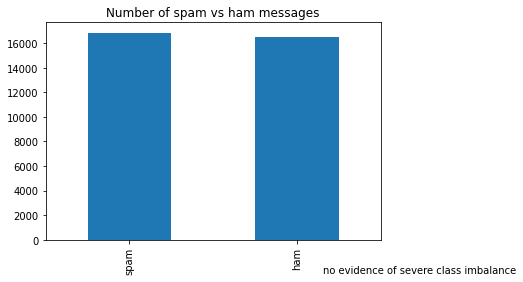

In [328]:
enron_eda['Spam/Ham'].value_counts().plot(kind = 'bar')
plt.figtext(0.99, 0.01, 'no evidence of severe class imbalance', horizontalalignment = 'center')
plt.title("Number of spam vs ham messages");

### 5.2 Tallying Word Frequency Per Message

In [329]:
def clean_msg_rm_lst(msg_tokens):
    
    text = ' '.join(msg_tokens)
    return text

enron_eda['clean_msg_no_lst'] = enron_eda['clean_msg_tokens'].apply(lambda x: clean_msg_rm_lst(x))

enron_eda.head(1)

,Subject,Message,Spam/Ham,target,!,"""",#,$,%,&,...,`,{,|,},~,msg_body_len,punct%,clean_msg_tokens,cleaned_msg,clean_msg_no_lst
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0,0,2,4,0,1,0,...,0,0,254,0,0,2823,40.5,"[gary, production, high, island, larger, block...",gary production high island larger block 1 2 c...,gary production high island larger block comme...


In [330]:
enron_eda['word_count'] = enron_eda['clean_msg_no_lst'].apply(lambda v : len(v.split(" ")))
print('Max number of words in a message: ', enron_eda['word_count'].max())
print('Min number of words in a message: ', enron_eda['word_count'].min())

Max number of words in a message:  20282
Min number of words in a message:  1


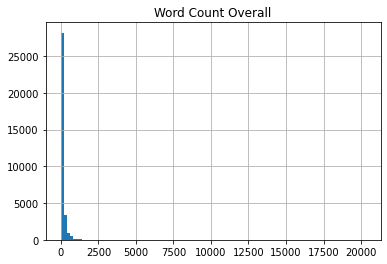

In [331]:
enron_eda['word_count'].hist(bins = 100)
plt.title('Word Count Overall');

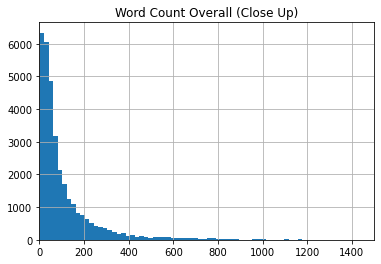

In [333]:
enron_eda['word_count'].hist(bins = 1000)
plt.title('Word Count Overall (Close Up)')
plt.xlim(-0.02, 1500);

### 5.3 Word Frequency Comparison (Spam vs Ham)

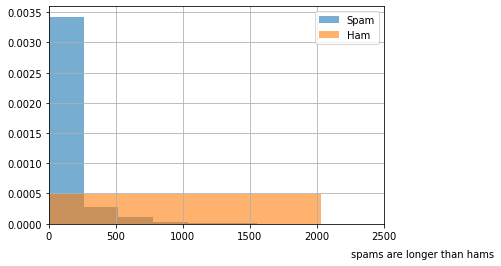

In [338]:
enron_eda[enron_eda['Spam/Ham'] == 'spam']['word_count'].hist(alpha = 0.6, density = True, label = 'Spam')
enron_eda[enron_eda['Spam/Ham'] == 'ham']['word_count'].hist(alpha = 0.6, density = True, label = 'Ham')
plt.legend()
plt.xlim(-0.02, 2500)
plt.figtext(0.99, 0.01, 'spams are longer than hams', horizontalalignment = 'center');

### 5.4 Punctuation Frequency Comparison (Spam vs Ham)

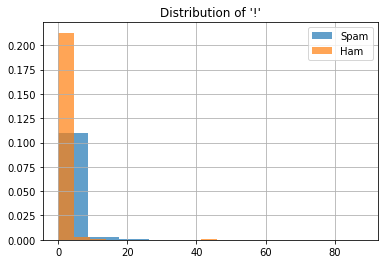

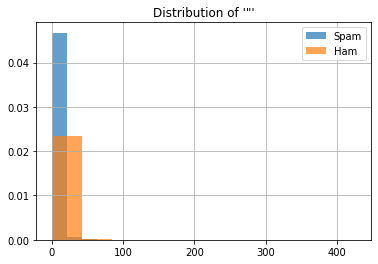

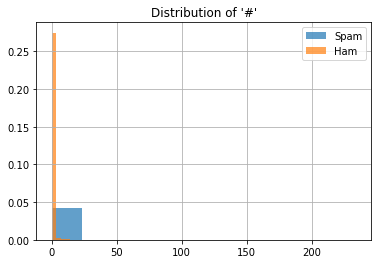

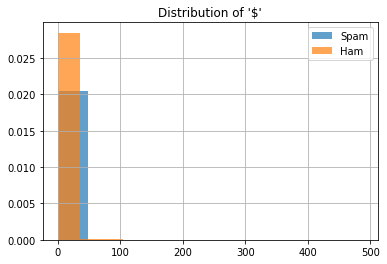

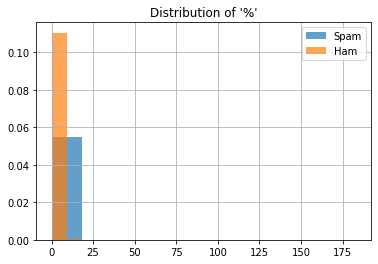

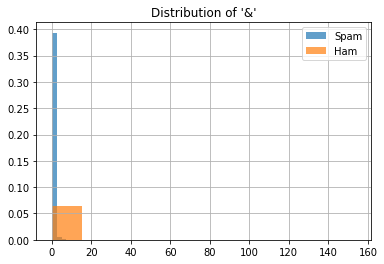

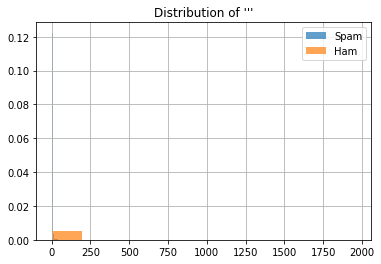

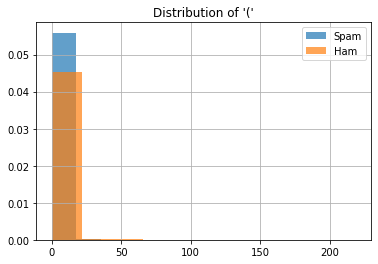

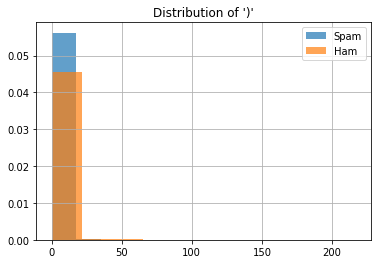

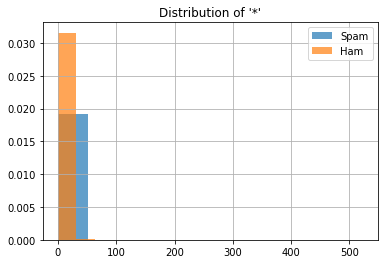

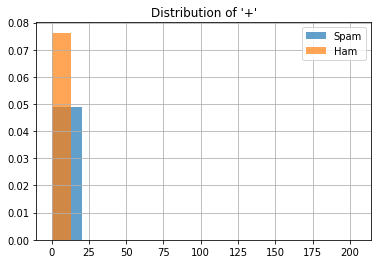

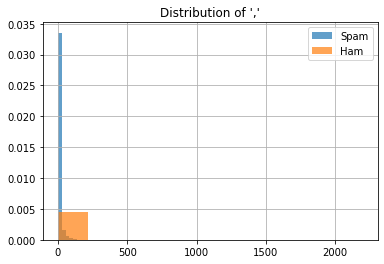

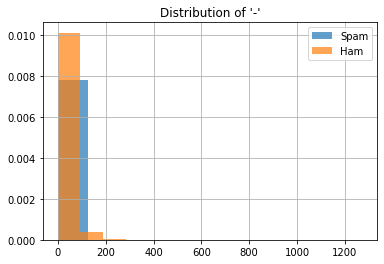

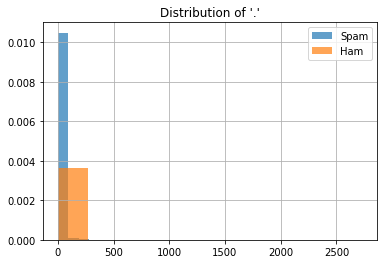

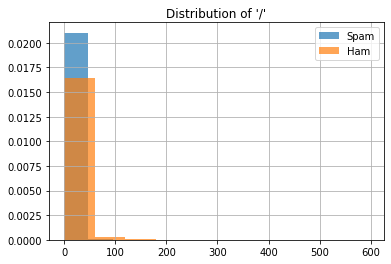

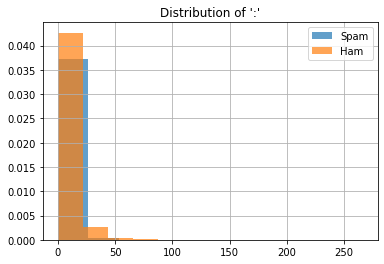

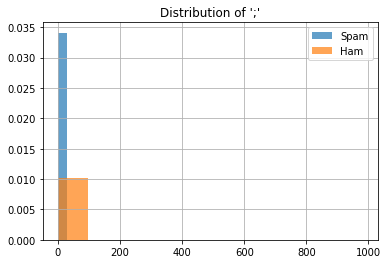

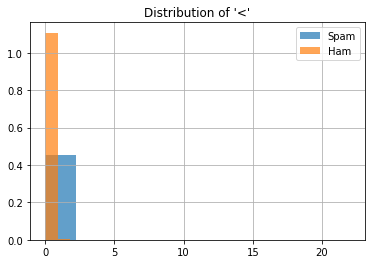

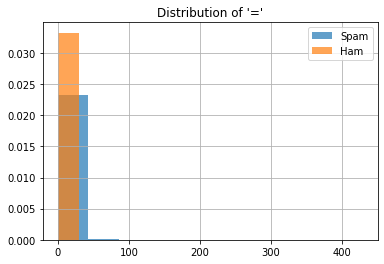

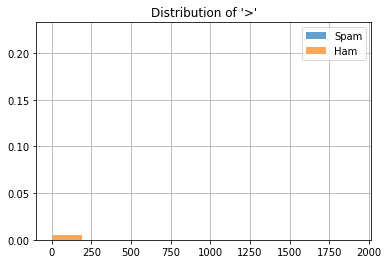

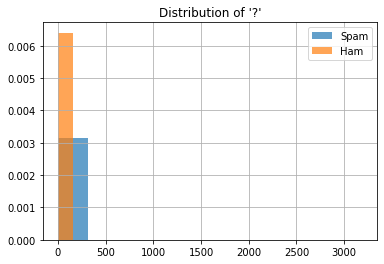

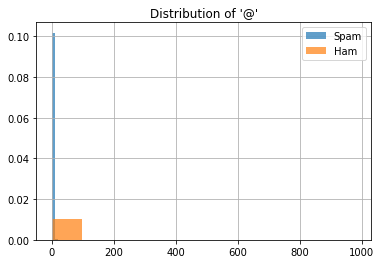

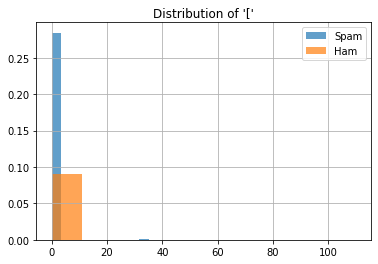

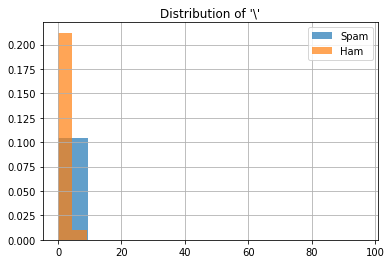

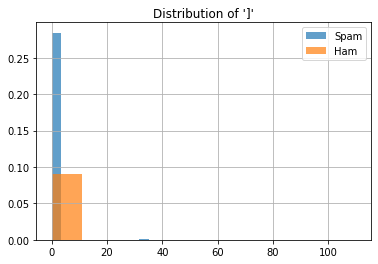

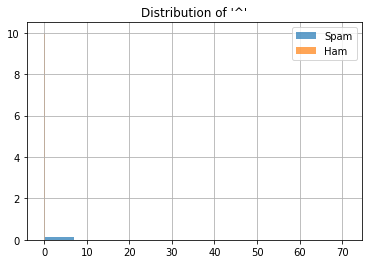

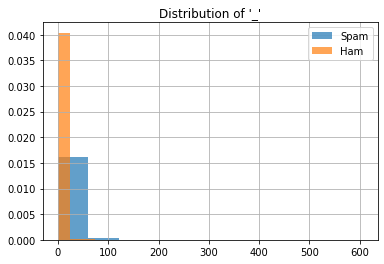

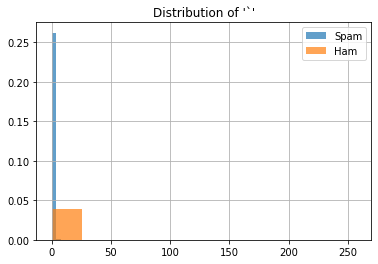

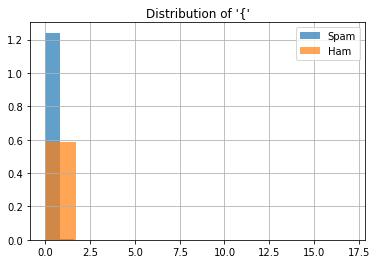

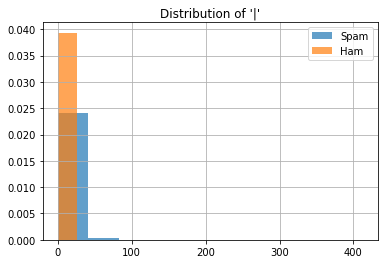

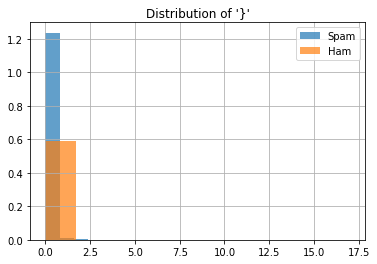

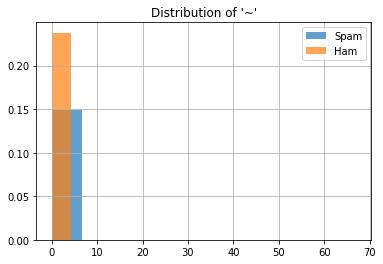

In [349]:
for punctu in string.punctuation:
    enron_eda[enron_eda['Spam/Ham'] == 'spam'][punctu].hist(alpha = 0.7, density = True, label = 'Spam')
    enron_eda[enron_eda['Spam/Ham'] == 'ham'][punctu].hist(alpha = 0.7, density = True, label = 'Ham')
    plt.legend()
    plt.title("Distribution of '" + punctu + "'")
    plt.show();